# 6.6 Sourcing & Analyzing Time Series Data

### This script contains the following points:
- **01. Importing Libraries & Data**
- **02. Create Subset for Each Region & Set Year as Index**
- **03. Create Line Charts for Each Region**
- **04. Decompose the Data & Test for Stationarity with the Dickey-Fuller Test**
- **05. Differencing Non-Stationary Data and Re-testing for Stationarity**
- **06. Checking Autocorrelations in Differenced Time Series**

## 01. Importing Libraries & Data

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
# Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import statsmodels.api as sm 
import os
# This is a library that handles warnings.
import warnings 
import matplotlib.ticker as ticker
# For formatting the year values in the line chart

# Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.
warnings.filterwarnings("ignore") 
plt.style.use('fivethirtyeight')

### My data is already time series data so I will be using my cleaned dataset.
- **Time Index:** The year column serves as the time index.
- **Regular Intervals:** The data is recorded at regular annual intervals.
- **Sequential Nature:** The data points are ordered chronologically by year.

In [2]:
# Turn Path into a String & Assign Python Shortcut
path = '/Users/mgottlieb/Documents/World Happiness Analysis'

In [3]:
# Import the dataset for this task
df_happiness = pd.read_csv(os.path.join(path, '02 Data', 'Prepared Data', 'df_happiness_flags_cleaned.csv'))

In [4]:
# Check the import
df_happiness.head()

,country_name,year,life_ladder,log_gdp_per_capita,social_support,healthy_life_expectancy_at_birth,freedom_to_make_life_choices,generosity,perceptions_of_corruption,positive_affect,negative_affect,region,democracy_status,life_ladder_group,broad_region,life_expectancy_group
0,Afghanistan,2008,3.723590,7.350416,0.450662,50.500000,0.718114,0.164055,0.881686,0.414297,0.258195,Southern Asia,Non-Democratic,Low,Asia,Medium
1,Afghanistan,2009,4.401778,7.508646,0.552308,50.799999,0.678896,0.187297,0.850035,0.481421,0.237092,Southern Asia,Non-Democratic,Low,Asia,Medium
2,Afghanistan,2010,4.758381,7.613900,0.539075,51.099998,0.600127,0.117861,0.706766,0.516907,0.275324,Southern Asia,Non-Democratic,Low,Asia,Medium
3,Afghanistan,2011,3.831719,7.581259,0.521104,51.400002,0.495901,0.160098,0.731109,0.479835,0.267175,Southern Asia,Non-Democratic,Low,Asia,Medium
4,Afghanistan,2012,3.782938,7.660506,0.520637,51.700001,0.530935,0.234157,0.775620,0.613513,0.267919,Southern Asia,Non-Democratic,Low,Asia,Medium


In [5]:
df_happiness.dtypes

country_name                         object
year                                  int64
life_ladder                         float64
log_gdp_per_capita                  float64
social_support                      float64
healthy_life_expectancy_at_birth    float64
freedom_to_make_life_choices        float64
generosity                          float64
perceptions_of_corruption           float64
positive_affect                     float64
negative_affect                     float64
region                               object
democracy_status                     object
life_ladder_group                    object
broad_region                         object
life_expectancy_group                object
dtype: object

In [6]:
# Get the sorted unique values of the 'year' column
unique_years_sorted = sorted(df_happiness['year'].unique())
print(unique_years_sorted)

[2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]


In [7]:
# Checking the unique values for broad_region for subsetting the data
df_happiness['broad_region'].unique()

array(['Asia', 'Europe', 'Africa & Middle East', 'Americas', 'Oceania'],
      dtype=object)

In [8]:
# Check for Missing Values
df_happiness.isnull().sum()

# There should be done as this is a cleaned dataset

country_name                        0
year                                0
life_ladder                         0
log_gdp_per_capita                  0
social_support                      0
healthy_life_expectancy_at_birth    0
freedom_to_make_life_choices        0
generosity                          0
perceptions_of_corruption           0
positive_affect                     0
negative_affect                     0
region                              0
democracy_status                    0
life_ladder_group                   0
broad_region                        0
life_expectancy_group               0
dtype: int64

In [9]:
# Check for duplicates
df_happiness.duplicated().sum()

# There should be done as this is a cleaned dataset

0

## 02. Create Subset for Each Region & Set Year as Index
For the purpose of my analysis I think it would make sense to create a subset of the data by calculating the mean of life_ladder for each region per year. This would allow me to analyze the overall trend of life satisfaction within each region over time.

**I also filtered years for those that were common across years so that there would be no empty values.**

In [11]:
# Find common years across all regions
common_years = df_happiness.groupby('year').filter(lambda x: x['life_ladder'].notna().all())['year'].unique()

In [12]:
common_years

array([2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018,
       2019, 2021, 2022, 2023, 2007, 2020, 2006, 2005])

In [56]:
# Define the common years in ascending order
common_years = [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]

#### Excluded 2005 because it was not representative of the general trend of the data, there were far less data points which I believe skewed the data.

### Africa & Middle East Subset

In [57]:
# Filter the dataframe for Africa & Middle East
df_africa_me_mean = df_happiness[df_happiness['broad_region'] == 'Africa & Middle East']

# Select only the common years and calculate the mean for life_ladder
df_africa_me_mean = df_africa_me_mean[df_africa_me_mean['year'].isin(common_years)]
df_africa_me_mean = df_africa_me_mean.groupby('year')['life_ladder'].mean().reset_index()

# Set year as the index
df_africa_me_mean.set_index('year', inplace=True)

In [58]:
# Checking the new dataset
df_africa_me_mean.isnull().sum()

life_ladder    0
dtype: int64

In [59]:
# Checking the new dataset
df_africa_me_mean.duplicated().sum()

0

### Americas Subset

In [60]:
# Filter the dataframe for Americas
df_americas_mean = df_happiness[df_happiness['broad_region'] == 'Americas']

# Select only the common years and calculate the mean for life_ladder
df_americas_mean = df_americas_mean[df_americas_mean['year'].isin(common_years)]
df_americas_mean = df_americas_mean.groupby('year')['life_ladder'].mean().reset_index()

# Set year as the index
df_americas_mean.set_index('year', inplace=True)

In [61]:
# Checking the new dataset
df_americas_mean.isnull().sum()

life_ladder    0
dtype: int64

In [62]:
# Checking the new dataset
df_americas_mean.duplicated().sum()

0

### Asia Subset

In [63]:
# Filter the dataframe for Asia
df_asia_mean = df_happiness[df_happiness['broad_region'] == 'Asia']

# Select only the common years and calculate the mean for life_ladder
df_asia_mean = df_asia_mean[df_asia_mean['year'].isin(common_years)]
df_asia_mean = df_asia_mean.groupby('year')['life_ladder'].mean().reset_index()

# Set year as the index
df_asia_mean.set_index('year', inplace=True)

In [64]:
# Checking the new dataset
df_asia_mean.isnull().sum()

life_ladder    0
dtype: int64

In [65]:
# Checking the new dataset
df_asia_mean.duplicated().sum()

0

### Europe Subset

In [66]:
# Filter the dataframe for Europe
df_europe_mean = df_happiness[df_happiness['broad_region'] == 'Europe']

# Select only the common years and calculate the mean for life_ladder
df_europe_mean = df_europe_mean[df_europe_mean['year'].isin(common_years)]
df_europe_mean = df_europe_mean.groupby('year')['life_ladder'].mean().reset_index()

# Set year as the index
df_europe_mean.set_index('year', inplace=True)

In [67]:
# Checking the new dataset
df_europe_mean.isnull().sum()

life_ladder    0
dtype: int64

In [68]:
# Checking the new dataset
df_europe_mean.duplicated().sum()

0

### Oceania Subset

In [69]:
# Filter the dataframe for Oceania
df_oceania_mean = df_happiness[df_happiness['broad_region'] == 'Oceania']

# Select only the common years and calculate the mean for life_ladder
df_oceania_mean = df_oceania_mean[df_oceania_mean['year'].isin(common_years)]
df_oceania_mean = df_oceania_mean.groupby('year')['life_ladder'].mean().reset_index()

# Set year as the index
df_oceania_mean.set_index('year', inplace=True)

In [70]:
# Checking the new dataset
df_oceania_mean.isnull().sum()

life_ladder    0
dtype: int64

In [71]:
# Checking the new dataset
df_oceania_mean.duplicated().sum()

0

## 03. Create Line Charts for Each Region

### Africa & Middle East

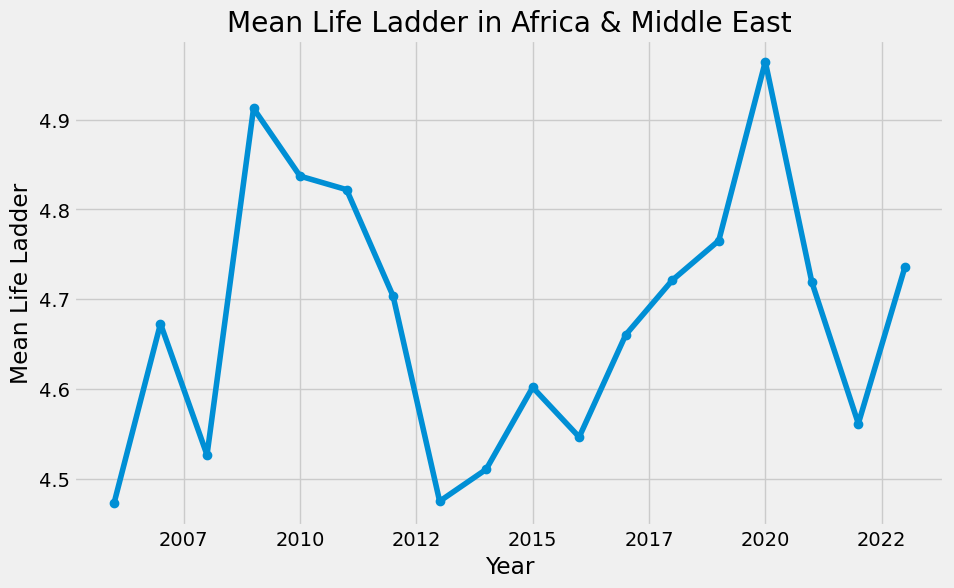

In [72]:
# Create line chart for Africa & Middle East with formatted x-axis
plt.figure(figsize=(10, 6))
plt.plot(df_africa_me_mean, marker='o')
plt.title('Mean Life Ladder in Africa & Middle East')
plt.xlabel('Year')
plt.ylabel('Mean Life Ladder')
plt.grid(True)
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x)}'))

# Export the chart
file_name = os.path.join(path, '04 Analysis', 'Visualizations', 'mean_life_ladder_africa_m_east.png')
plt.savefig(file_name)


plt.show()

### Americas

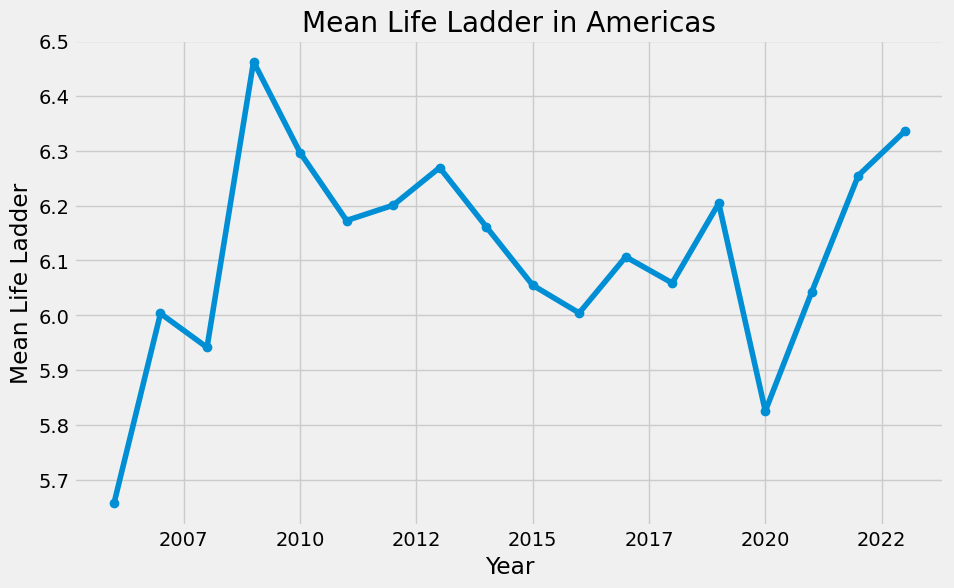

In [73]:
# Create line chart for Americas with formatted x-axis
plt.figure(figsize=(10, 6))
plt.plot(df_americas_mean, marker='o')
plt.title('Mean Life Ladder in Americas')
plt.xlabel('Year')
plt.ylabel('Mean Life Ladder')
plt.grid(True)
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x)}'))

# Export the chart
file_name = os.path.join(path, '04 Analysis', 'Visualizations', 'mean_life_ladder_americas.png')
plt.savefig(file_name)


plt.show()

### Asia

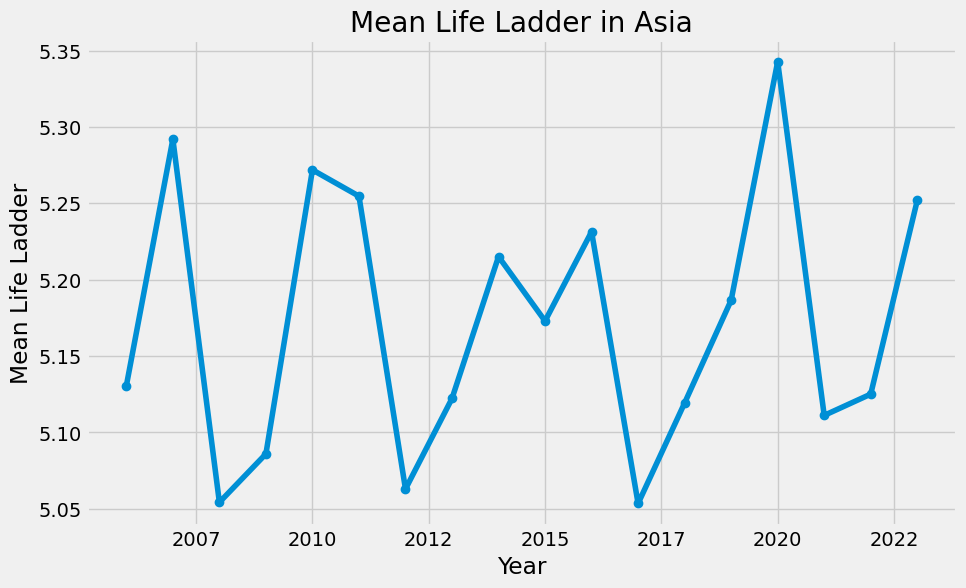

In [74]:
# Create line chart for Asia with formatted x-axis
plt.figure(figsize=(10, 6))
plt.plot(df_asia_mean, marker='o')
plt.title('Mean Life Ladder in Asia')
plt.xlabel('Year')
plt.ylabel('Mean Life Ladder')
plt.grid(True)
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x)}'))

# Export the chart
file_name = os.path.join(path, '04 Analysis', 'Visualizations', 'mean_life_ladder_asia.png')
plt.savefig(file_name)


plt.show()

### Europe

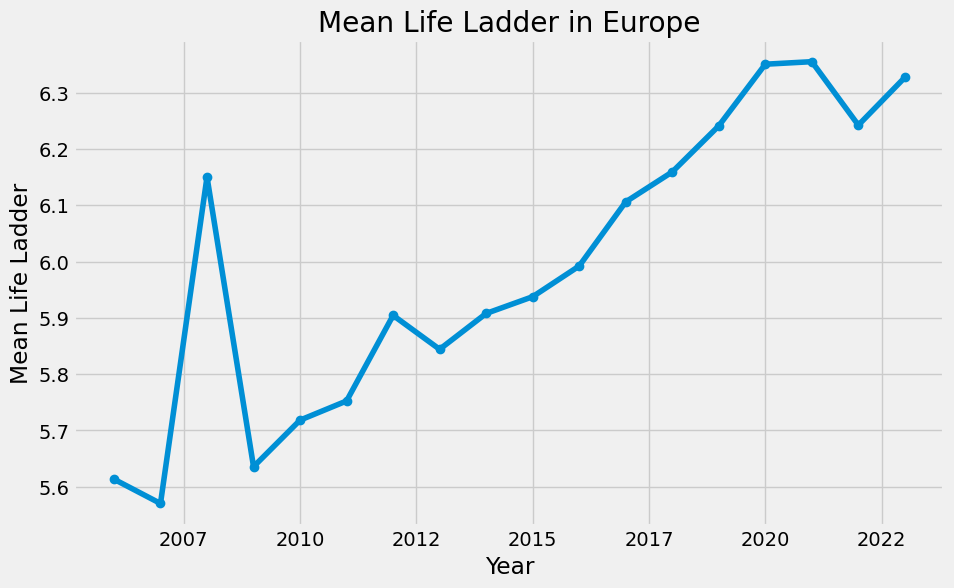

In [75]:
# Create line chart for Europe with formatted x-axis
plt.figure(figsize=(10, 6))
plt.plot(df_europe_mean, marker='o')
plt.title('Mean Life Ladder in Europe')
plt.xlabel('Year')
plt.ylabel('Mean Life Ladder')
plt.grid(True)
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x)}'))
# Export the chart
file_name = os.path.join(path, '04 Analysis', 'Visualizations', 'mean_life_ladder_europe.png')
plt.savefig(file_name)


plt.show()

### Oceania

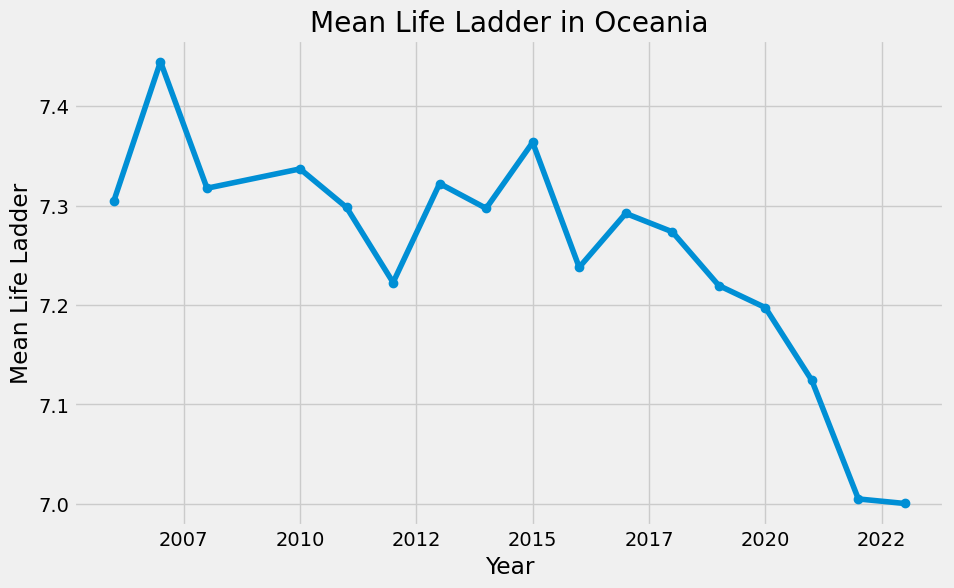

In [76]:
# Create line chart for Oceania with formatted x-axis
plt.figure(figsize=(10, 6))
plt.plot(df_oceania_mean, marker='o')
plt.title('Mean Life Ladder in Oceania')
plt.xlabel('Year')
plt.ylabel('Mean Life Ladder')
plt.grid(True)
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x)}'))

# Export the chart
file_name = os.path.join(path, '04 Analysis', 'Visualizations', 'mean_life_ladder_oceania.png')
plt.savefig(file_name)


plt.show()

## 04. Decompose the Data & Test for Stationarity with the Dickey-Fuller Test
Decomposing the data breaks down the data into its fundamental parts:
- Trend
- Seasonality
- Residuals\
\
I will be using the additive model like in the example.

The data will also be tested with the Dickey-Fuller test. This is a statistical test used to determine whether a time series is stationary or not.

### Africa & Middle East

In [77]:
# Example: Decomposing the time series for Asia
decomposition_africa_me = sm.tsa.seasonal_decompose(df_africa_me_mean['life_ladder'], model='additive', period=1)

# Extract the components
trend_africa_me = decomposition_africa_me.trend
seasonal_africa_me = decomposition_africa_me.seasonal
residual_africa_me = decomposition_africa_me.resid

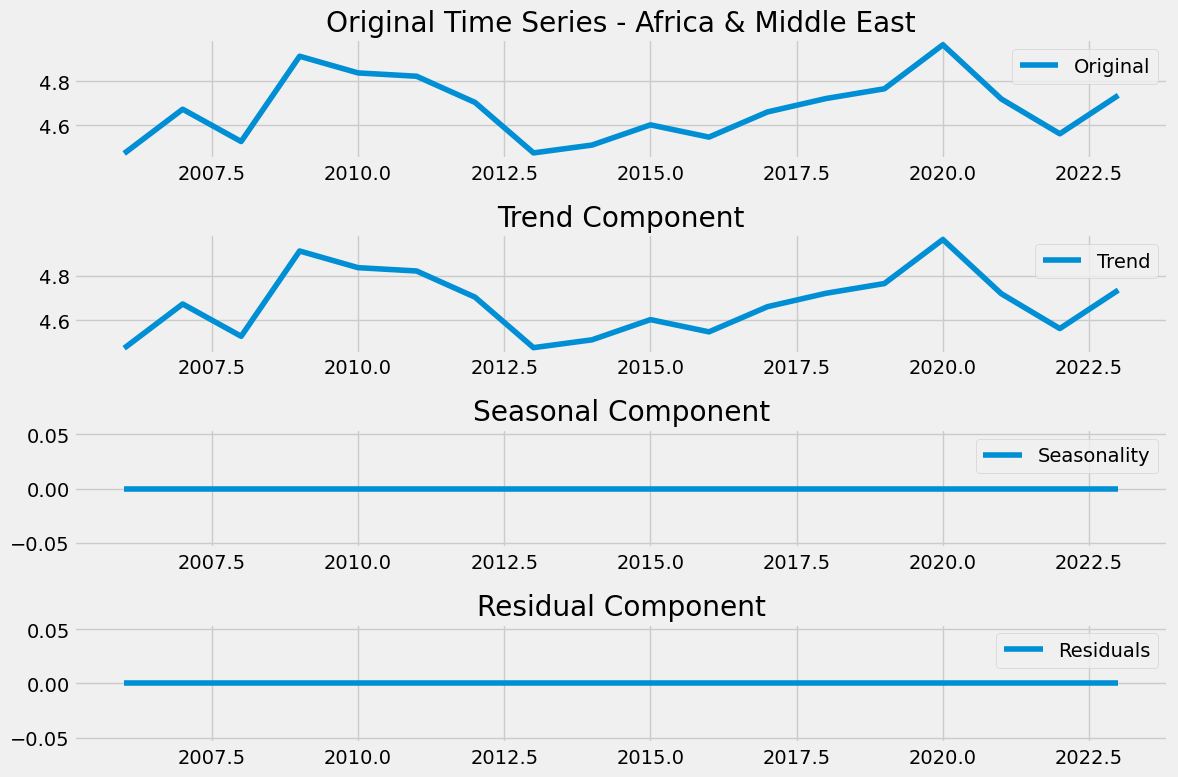

In [78]:
# Plotting the decomposition
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(df_africa_me_mean['life_ladder'], label='Original')
plt.title('Original Time Series - Africa & Middle East')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend_africa_me, label='Trend')
plt.title('Trend Component')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal_africa_me, label='Seasonality')
plt.title('Seasonal Component')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual_africa_me, label='Residuals')
plt.title('Residual Component')
plt.legend(loc='best')
plt.tight_layout()

# Export the chart
file_name = os.path.join(path, '04 Analysis', 'Visualizations', 'decomposition_africa_me.png')
plt.savefig(file_name)

plt.show()

- **Time Series** - Some variability, a rise and then steady drop after about 2009 and 2020 which does cooincide with the housing crisis and Covid
- **Trend** - Mimics the time series line
- **Seasonality** - Constant line, no seasonal patterns
- **Residual** - Constant line, minimal variability 

In [79]:
from statsmodels.tsa.stattools import adfuller

In [80]:
def dickey_fuller(timeseries):
    print('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic', 'p-value', 'Number of Lags Used', 'Number of Observations Used'])
    for key, value in test[4].items():
        result['Critical Value (%s)' % key] = value
    print(result)

In [81]:
# Apply the test for Africa & Middle East
dickey_fuller(df_africa_me_mean['life_ladder'])

Dickey-Fuller Stationarity test:
Test Statistic                 -3.472054
p-value                         0.008734
Number of Lags Used             6.000000
Number of Observations Used    11.000000
Critical Value (1%)            -4.223238
Critical Value (5%)            -3.189369
Critical Value (10%)           -2.729839
dtype: float64


- The test statistic is -3.472054, which is lower than the critical values at the 5% and 10% significance levels but higher than the critical value at the 1% significance level.
=The p-value is 0.008734, which is lower than 0.05 (5%).\
\
The test results indicate that the null hypothesis (that the time series has a unit root and is non-stationary) can be rejected at the 5% significance level. Therefore, the time series data for life ladder in Africa and the Middle East is stationary.

#### Africa and the Middle East is stationary

### Americas

In [82]:
# Decompose the time series for Americas
decomposition_americas = sm.tsa.seasonal_decompose(df_americas_mean['life_ladder'], model='additive', period=1)
trend_americas = decomposition_americas.trend
seasonal_americas = decomposition_americas.seasonal
residual_americas = decomposition_americas.resid

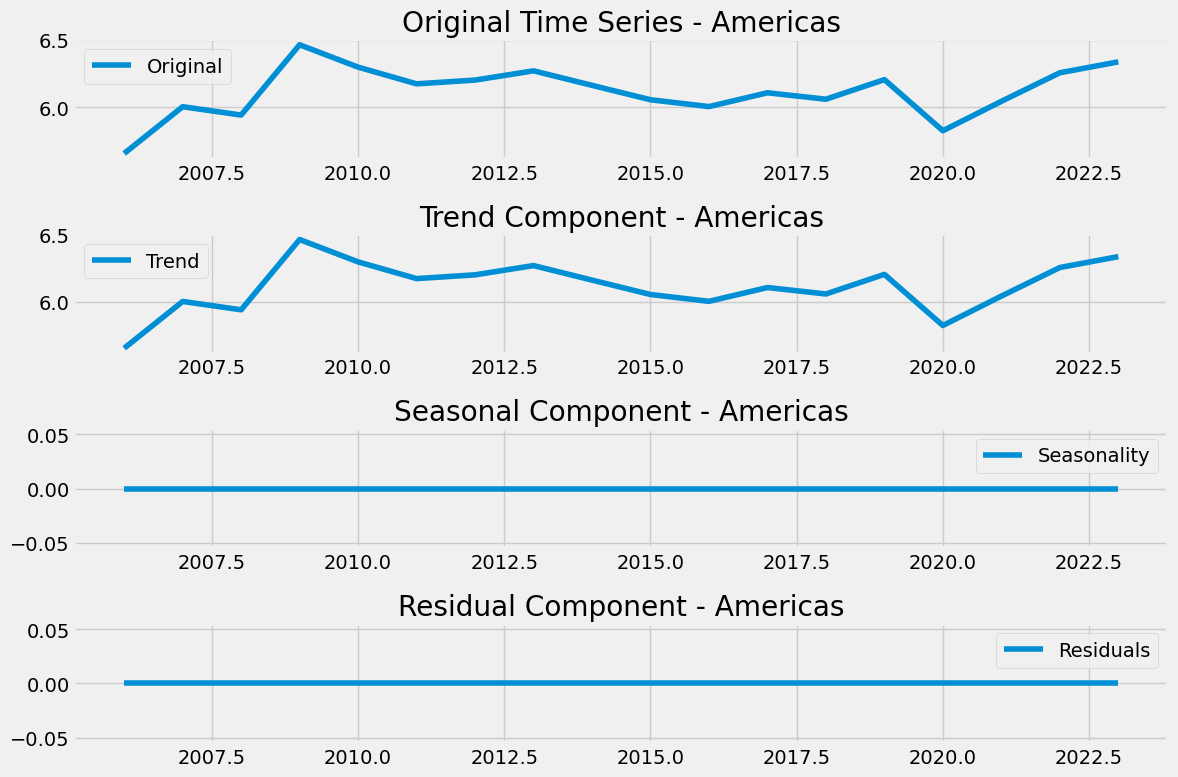

In [83]:
# Plotting the decomposition
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(df_americas_mean['life_ladder'], label='Original')
plt.title('Original Time Series - Americas')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend_americas, label='Trend')
plt.title('Trend Component - Americas')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal_americas, label='Seasonality')
plt.title('Seasonal Component - Americas')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual_americas, label='Residuals')
plt.title('Residual Component - Americas')
plt.legend(loc='best')
plt.tight_layout()

# Export the chart
file_name = os.path.join(path, '04 Analysis', 'Visualizations', 'decomposition_americas.png')
plt.savefig(file_name)

plt.show()

- **Time Series** - Some variability, a rise and then steady drop after about 2009, a steady decline until a sharp drop in 2020 which does cooincide with the housing crisis and Covid
- **Trend** - Mimics the time series line
- **Seasonality** - Constant line, no seasonal patterns
- **Residual** - Constant line, minimal variability 

In [84]:
# Apply the test for Americas
dickey_fuller(df_americas_mean['life_ladder'])

Dickey-Fuller Stationarity test:
Test Statistic                 -2.264985
p-value                         0.183510
Number of Lags Used             7.000000
Number of Observations Used    10.000000
Critical Value (1%)            -4.331573
Critical Value (5%)            -3.232950
Critical Value (10%)           -2.748700
dtype: float64


- The test statistic is -2.264985, which is higher than the critical values at the 1% and 5% significance levels but lower than the critical value at the 10% significance level.
- The p-value is 0.183510, which is higher than 0.05 (5%).\
\
The test results indicate that the null hypothesis (that the time series has a unit root and is non-stationary) cannot be rejected at the 5% significance level but can be rejected at the 10% significance level. Therefore, the time series data for life ladder in the Americas is likely non-stationary.

#### Americas is non-stationary

### Asia

In [85]:
# Decompose the time series for Asia
decomposition_asia = sm.tsa.seasonal_decompose(df_asia_mean['life_ladder'], model='additive', period=1)
trend_asia = decomposition_asia.trend
seasonal_asia = decomposition_asia.seasonal
residual_asia = decomposition_asia.resid

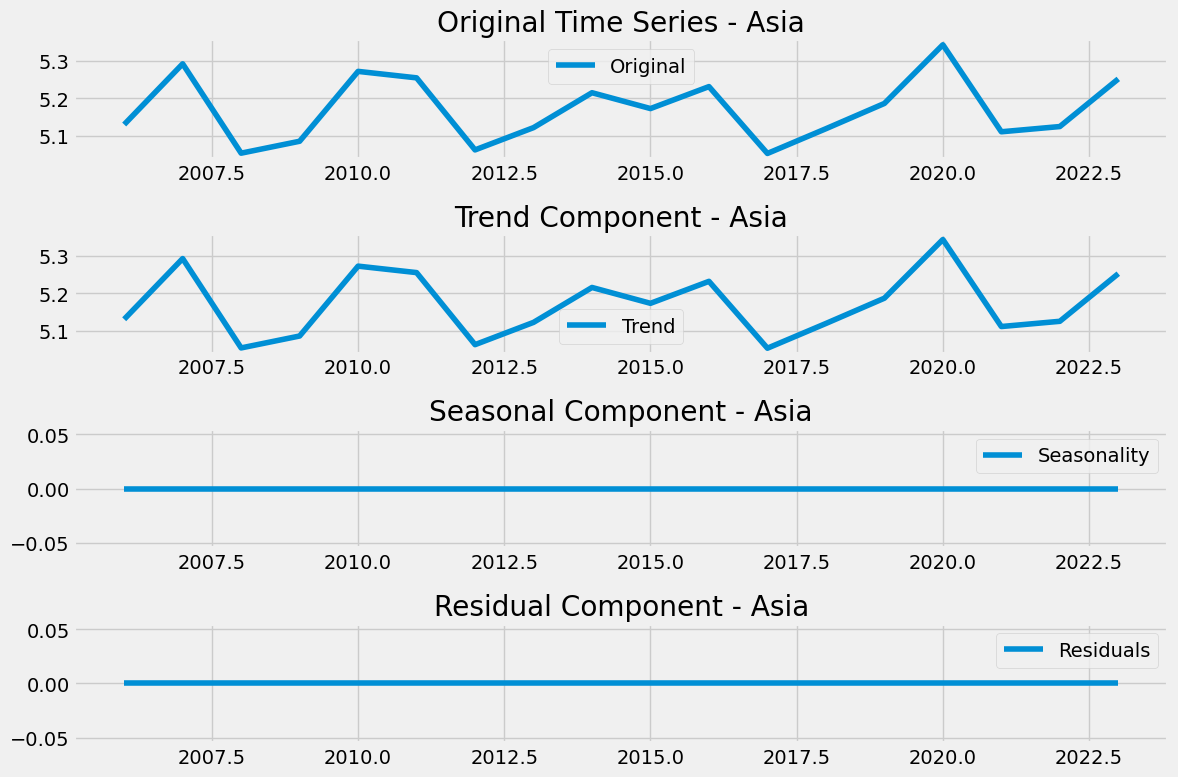

In [86]:
# Plotting the decomposition
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(df_asia_mean['life_ladder'], label='Original')
plt.title('Original Time Series - Asia')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend_asia, label='Trend')
plt.title('Trend Component - Asia')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal_asia, label='Seasonality')
plt.title('Seasonal Component - Asia')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual_asia, label='Residuals')
plt.title('Residual Component - Asia')
plt.legend(loc='best')
plt.tight_layout()

# Export the chart
file_name = os.path.join(path, '04 Analysis', 'Visualizations', 'decomposition_asia.png')
plt.savefig(file_name)

plt.show()

- **Time Series** - Noticeable fluctuations over the years, some variability
- **Trend** - Mimics the time series line
- **Seasonality** - Constant line, no seasonal patterns
- **Residual** - Constant line, minimal variability 

In [87]:
# Apply the test for Asia
dickey_fuller(df_asia_mean['life_ladder'])

Dickey-Fuller Stationarity test:
Test Statistic                 -2.332576
p-value                         0.161677
Number of Lags Used             7.000000
Number of Observations Used    10.000000
Critical Value (1%)            -4.331573
Critical Value (5%)            -3.232950
Critical Value (10%)           -2.748700
dtype: float64


- The test statistic is -2.332576, which is not lower than all the critical values at the 1%, 5%, and 10% significance levels. It is higher than the critical value at the 1% and 5% levels.
- The p-value is 0.161677, which is significantly higher than 0.05 (5%).\
\
The test results indicate that the null hypothesis (that the time series has a unit root and is non-stationary) cannot be rejected. Therefore, the time series data for life ladder in Asia is not stationary.

#### Asia is non-stationary

### Europe

In [88]:
# Decompose the time series for Europe
decomposition_europe = sm.tsa.seasonal_decompose(df_europe_mean['life_ladder'], model='additive', period=1)
trend_europe = decomposition_europe.trend
seasonal_europe = decomposition_europe.seasonal
residual_europe = decomposition_europe.resid

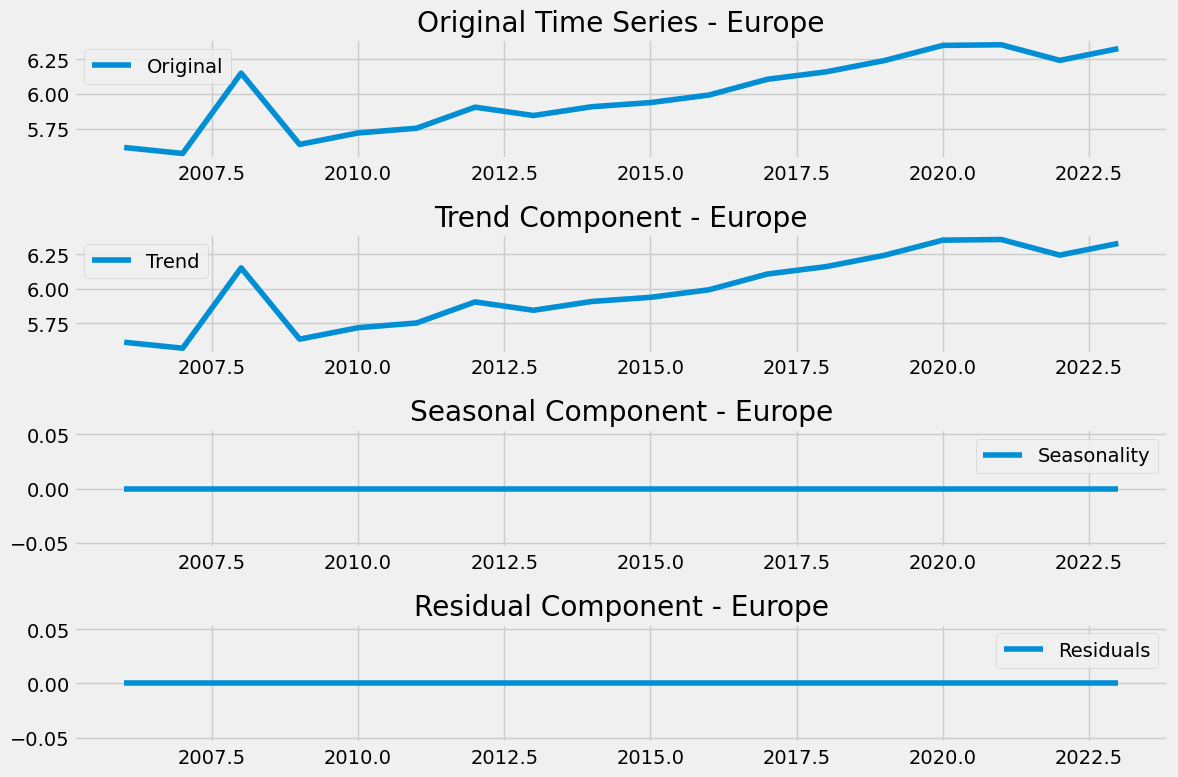

In [89]:
# Plotting the decomposition
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(df_europe_mean['life_ladder'], label='Original')
plt.title('Original Time Series - Europe')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend_europe, label='Trend')
plt.title('Trend Component - Europe')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal_europe, label='Seasonality')
plt.title('Seasonal Component - Europe')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual_europe, label='Residuals')
plt.title('Residual Component - Europe')
plt.legend(loc='best')
plt.tight_layout()

# Export the chart
file_name = os.path.join(path, '04 Analysis', 'Visualizations', 'decomposition_europe.png')
plt.savefig(file_name)

plt.show()

- **Time Series** - Some variability, a rise and then steady drop after about 2008, a steady decline incline until about 2021
- **Trend** - Mimics the time series line
- **Seasonality** - Constant line, no seasonal patterns
- **Residual** - Constant line, minimal variability 

In [90]:
# Apply the test for Europe
dickey_fuller(df_europe_mean['life_ladder'])

Dickey-Fuller Stationarity test:
Test Statistic                 -1.762249
p-value                         0.399359
Number of Lags Used             0.000000
Number of Observations Used    17.000000
Critical Value (1%)            -3.889266
Critical Value (5%)            -3.054358
Critical Value (10%)           -2.666984
dtype: float64


- The test statistic is -1.762249, which is higher than the critical values at the 1%, 5%, and 10% significance levels.
- The p-value is 0.399359, which is higher than 0.05 (5%).\
\
The test results indicate that the null hypothesis (that the time series has a unit root and is non-stationary) cannot be rejected. Therefore, the time series data for life ladder in Europe is not stationary.

#### Europe is non-stationary

### Oceania

In [91]:
# Decompose the time series for Oceania
decomposition_oceania = sm.tsa.seasonal_decompose(df_oceania_mean['life_ladder'], model='additive', period=1)
trend_oceania = decomposition_oceania.trend
seasonal_oceania = decomposition_oceania.seasonal
residual_oceania = decomposition_oceania.resid

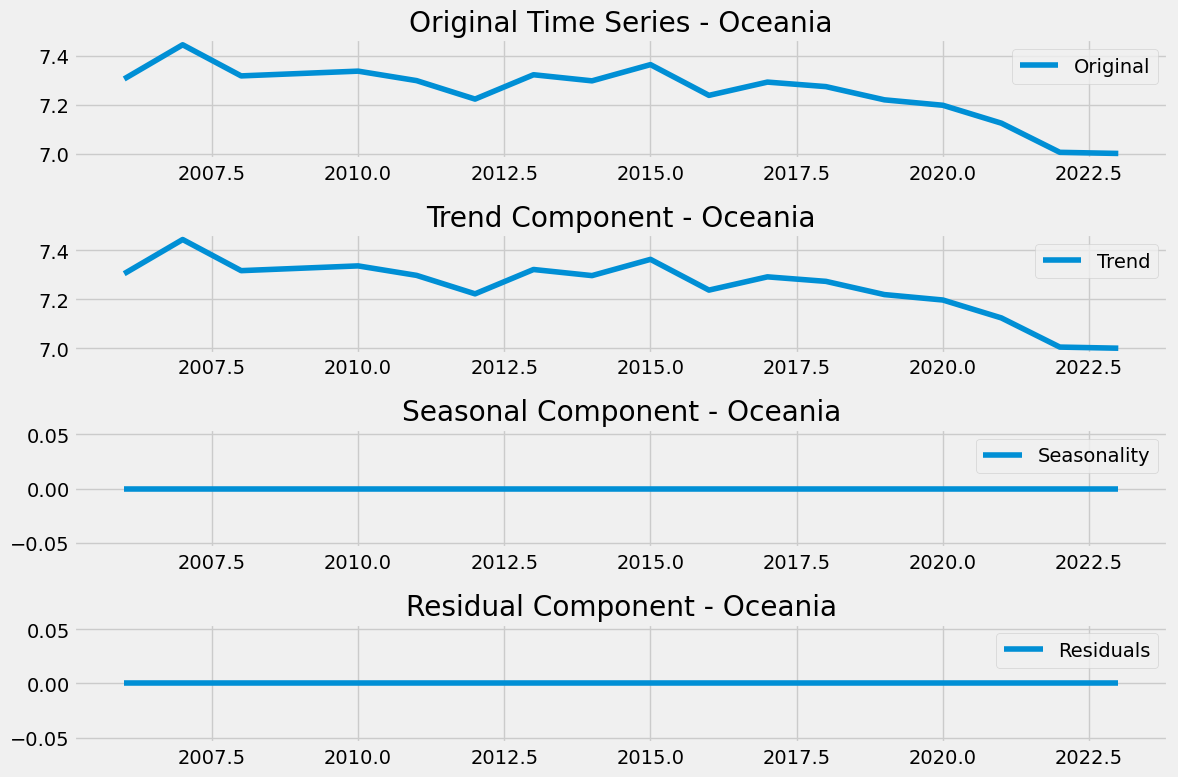

In [92]:
# Plotting the decomposition
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(df_oceania_mean['life_ladder'], label='Original')
plt.title('Original Time Series - Oceania')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend_oceania, label='Trend')
plt.title('Trend Component - Oceania')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal_oceania, label='Seasonality')
plt.title('Seasonal Component - Oceania')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual_oceania, label='Residuals')
plt.title('Residual Component - Oceania')
plt.legend(loc='best')
plt.tight_layout()

# Export the chart
file_name = os.path.join(path, '04 Analysis', 'Visualizations', 'decomposition_oceania.png')
plt.savefig(file_name)

plt.show()

- **Time Series** - Noticeable fluctuations, with a sharp downward trend in about 2006 and 2015
- **Trend** - Mimics the time series line
- **Seasonality** - Constant line, no seasonal patterns
- **Residual** - Constant line, minimal variability 

In [93]:
# Apply the test for Oceania
dickey_fuller(df_oceania_mean['life_ladder'])

Dickey-Fuller Stationarity test:
Test Statistic                  0.813428
p-value                         0.991850
Number of Lags Used             1.000000
Number of Observations Used    15.000000
Critical Value (1%)            -3.964443
Critical Value (5%)            -3.084908
Critical Value (10%)           -2.681814
dtype: float64


- The test statistic is 0.813428, which is higher than all the critical values at the 1%, 5%, and 10% significance levels.
- The p-value is 0.991850, which is significantly higher than 0.05 (5%).\
\
The test results indicate that the null hypothesis (that the time series has a unit root and is non-stationary) cannot be rejected. Therefore, the time series data for life ladder in Oceania is non-stationary.

#### Oceania is non-stationary

### Stationary Regions
- Africa & Middle East

### Non-Stationary Regions
- Asia
- Americas
- Europe
- Oceania

## 05. Differencing Non-Stationary Data and Re-testing for Stationarity

In [94]:
def differencing(df):
    return df.diff().dropna()

def dickey_fuller(timeseries):
    print('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key, value in test[4].items():
        result['Critical Value (%s)' % key] = value
    print(result)
    print()

In [98]:
# Americas
df_americas_diff = differencing(df_americas_mean['life_ladder'])
print("Americas Differenced")
dickey_fuller(df_americas_diff)

Americas Differenced
Dickey-Fuller Stationarity test:
Test Statistic                 -4.123095
p-value                         0.000887
Number of Lags Used             2.000000
Number of Observations Used    14.000000
Critical Value (1%)            -4.012034
Critical Value (5%)            -3.104184
Critical Value (10%)           -2.690987
dtype: float64



In [100]:
# Second round of differencing for the Americas
df_americas_diff2 = df_americas_mean.diff().dropna().diff().dropna()

# Perform the Dickey-Fuller test again
dickey_fuller(df_asia_diff2['life_ladder'])

Dickey-Fuller Stationarity test:
Test Statistic                 0.031330
p-value                        0.961048
Number of Lags Used            6.000000
Number of Observations Used    9.000000
Critical Value (1%)           -4.473135
Critical Value (5%)           -3.289881
Critical Value (10%)          -2.772382
dtype: float64



In [101]:
# Third round of differencing for the Americas
df_americas_diff3 = df_americas_diff2.diff().dropna()

# Perform the Dickey-Fuller test again
dickey_fuller(df_americas_diff3['life_ladder'])

Dickey-Fuller Stationarity test:
Test Statistic                -1.939623
p-value                        0.313657
Number of Lags Used            5.000000
Number of Observations Used    9.000000
Critical Value (1%)           -4.473135
Critical Value (5%)           -3.289881
Critical Value (10%)          -2.772382
dtype: float64



In [102]:
# Apply log transformation
df_americas_mean['log_life_ladder'] = np.log(df_americas_mean['life_ladder'])

# First round of differencing
df_americas_log_diff = df_americas_mean['log_life_ladder'].diff().dropna()

# Perform the Dickey-Fuller test again
dickey_fuller(df_americas_log_diff)

Dickey-Fuller Stationarity test:
Test Statistic                 -4.064798
p-value                         0.001107
Number of Lags Used             2.000000
Number of Observations Used    14.000000
Critical Value (1%)            -4.012034
Critical Value (5%)            -3.104184
Critical Value (10%)           -2.690987
dtype: float64



### Americas is now stationary after three rounds of differencing and then applying the log transformation

In [95]:
# Asia
df_asia_diff = differencing(df_asia_mean['life_ladder'])
print("Asia Differenced")
dickey_fuller(df_asia_diff)

Asia Differenced
Dickey-Fuller Stationarity test:
Test Statistic                  0.836223
p-value                         0.992199
Number of Lags Used             6.000000
Number of Observations Used    10.000000
Critical Value (1%)            -4.331573
Critical Value (5%)            -3.232950
Critical Value (10%)           -2.748700
dtype: float64



In [96]:
# Second round of differencing for Asia
df_asia_diff2 = df_asia_mean.diff().dropna().diff().dropna()

# Perform the Dickey-Fuller test again
dickey_fuller(df_asia_diff2['life_ladder'])

Dickey-Fuller Stationarity test:
Test Statistic                 0.031330
p-value                        0.961048
Number of Lags Used            6.000000
Number of Observations Used    9.000000
Critical Value (1%)           -4.473135
Critical Value (5%)           -3.289881
Critical Value (10%)          -2.772382
dtype: float64



In [97]:
# Third round of differencing for Asia
df_asia_diff3 = df_asia_diff2.diff().dropna()

# Perform the Dickey-Fuller test again
dickey_fuller(df_asia_diff3['life_ladder'])

Dickey-Fuller Stationarity test:
Test Statistic                -28.670011
p-value                         0.000000
Number of Lags Used             5.000000
Number of Observations Used     9.000000
Critical Value (1%)            -4.473135
Critical Value (5%)            -3.289881
Critical Value (10%)           -2.772382
dtype: float64



### Asia is now stationary after the third round of differencing

In [103]:
# Europe
df_europe_diff = differencing(df_europe_mean['life_ladder'])
print("Europe Differenced")
dickey_fuller(df_europe_diff)

Europe Differenced
Dickey-Fuller Stationarity test:
Test Statistic                -7.201744e+00
p-value                        2.355702e-10
Number of Lags Used            0.000000e+00
Number of Observations Used    1.600000e+01
Critical Value (1%)           -3.924019e+00
Critical Value (5%)           -3.068498e+00
Critical Value (10%)          -2.673893e+00
dtype: float64



### Europe is now stationary after applying differencing

In [104]:
# Oceania
df_oceania_diff = differencing(df_oceania_mean['life_ladder'])
print("Oceania Differenced")
dickey_fuller(df_oceania_diff)

Oceania Differenced
Dickey-Fuller Stationarity test:
Test Statistic                -7.196515e+00
p-value                        2.426702e-10
Number of Lags Used            0.000000e+00
Number of Observations Used    1.500000e+01
Critical Value (1%)           -3.964443e+00
Critical Value (5%)           -3.084908e+00
Critical Value (10%)          -2.681814e+00
dtype: float64



### Oceania is now stationary after applying differencing

## 06. Checking Autocorrelations in Differenced Time Series

In [112]:
from statsmodels.graphics.tsaplots import plot_acf

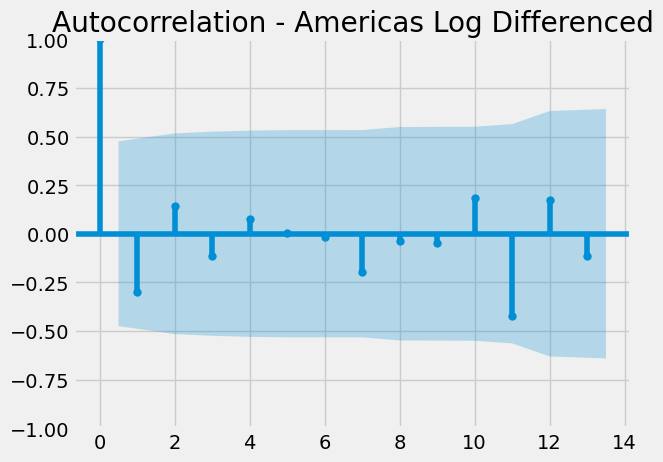

In [116]:
# Americas
plot_acf(df_americas_log_diff)
plt.title('Autocorrelation - Americas Log Differenced')
plt.show()

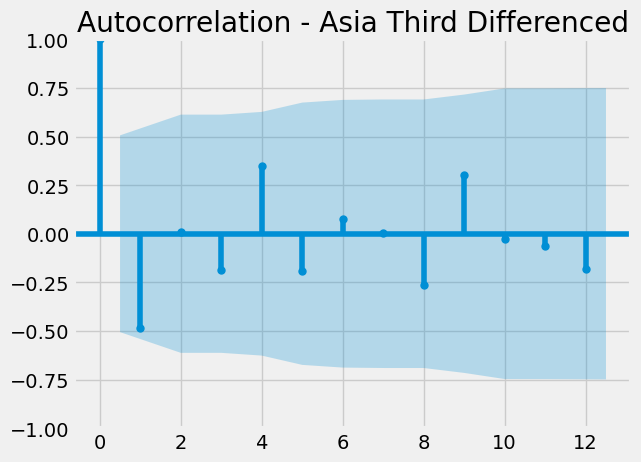

In [115]:
# Asia
plot_acf(df_asia_diff3)
plt.title('Autocorrelation - Asia Third Differenced')
plt.show()

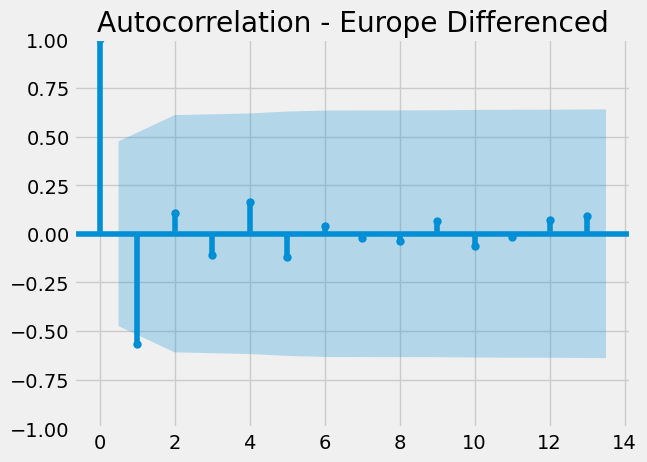

In [117]:
# Europe
plot_acf(df_europe_diff)
plt.title('Autocorrelation - Europe Differenced')
plt.show()

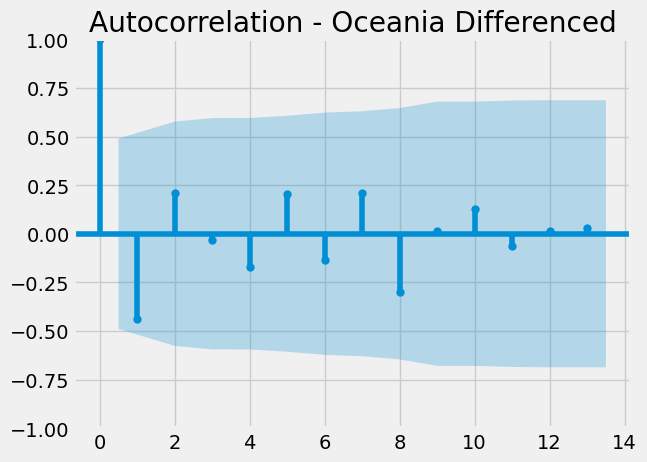

In [118]:
# Oceania
plot_acf(df_oceania_diff)
plt.title('Autocorrelation - Oceania Differenced')
plt.show()

### Conclusions
Overall, while the autocorrelation plots have improved, indicating a move towards stronger stationarity, there are still some autocorrelated terms present, meaning the stationarity is not yet strong.
- **Americas:**: Autocorrelation plot has improved, although data's stationarity has strengthened, it is not perfect.
- **Asia:** Some remaining autocorrelation even after the third differencing, some improvement.
- **Europe:** Some remaining autocorrelation after differencing, but definitely some improvement and a stronger stationarity.
- **Oceania:** Some remaining autocorrelation after differencing, although data's stationarity has strengthened, it is not perfect.